In [ ]:
import os
os.environ["KAGGLE_CONFIG_DIR"]= "/content" #folder

In [ ]:
!kaggle datasets download -d francismon/curated-colon-dataset-for-deep-learning

100% 1.41G/1.41G [00:51<00:00, 30.6MB/s]
100% 1.41G/1.41G [00:51<00:00, 29.2MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/0_normal/train_normal_ (28).jpg  
  inflating: train/0_normal/train_normal_ (280).jpg  
  inflating: train/0_normal/train_normal_ (281).jpg  
  inflating: train/0_normal/train_normal_ (282).jpg  
  inflating: train/0_normal/train_normal_ (283).jpg  
  inflating: train/0_normal/train_normal_ (284).jpg  
  inflating: train/0_normal/train_normal_ (285).jpg  
  inflating: train/0_normal/train_normal_ (286).jpg  
  inflating: train/0_normal/train_normal_ (287).jpg  
  inflating: train/0_normal/train_normal_ (288).jpg  
  inflating: train/0_normal/train_normal_ (289).jpg  
  inflating: train/0_normal/train_normal_ (29).jpg  
  inflating: train/0_normal/train_normal_ (290).jpg  
  inflating: train/0_normal/train_normal_ (291).jpg  
  inflating: train/0_normal/train_normal_ (292).jpg  
  inflating: train/0_normal/train_normal_ (293).jpg  
  inflating: train/0_normal/train_normal_ (294).jpg  
  inflating: train/0_normal/train

In [ ]:
!pip install keras-flops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import time
import pickle
import logging
import itertools
import scikitplot
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

from keras_flops import get_flops
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import applications
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from keras.utils.layer_utils import count_params
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, classification_report, confusion_matrix, roc_curve, auc

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import AveragePooling2D, AlphaDropout, Activation, Add, BatchNormalization, Concatenate, Layer, ReLU, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout

#Models 
from tensorflow.keras.applications.inception_v3 import InceptionV3 as trainable_model_a 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2 as trainable_model_b




In [ ]:


#Set constants 
#NOTE: These can be tuned if needed.
batch_size = 32
epochs = 5
optimizer = Adam(learning_rate=0.00001)
architecture = 'MFuReCNN_alpha_do_1'



In [ ]:
#Set model identifiers
DCNN_A = 'DCNN_A' #inception
DCNN_B = 'DCNN_B' #resnet


In [ ]:
#Custom save function
def save_h(file, history):
    with open(file + '/' + architecture + '/' + architecture + '.history', 'wb') as file_pi:
        pickle.dump(history, file_pi)
    print("history saved")

In [ ]:
#LOAD THE DATA


#Data split
train_data_dir = "/content/train"
validation_data_dir ="/content/val"
test_data_dir = "/content/test"

#Set image shapes
img_rows, img_cols = 224, 224
input_shape = (img_rows,img_cols,3)
model_input = Input(shape=input_shape)

#Prompt
print("Data folders found!")
print("The Input size is set to ", model_input)

Data folders found!
The Input size is set to  KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [ ]:
#DATA GENERATORS
#Augment Training Data
class_names = ['0_normal', 
                '1_ulcerative_colitis', 
                '2_polyps', 
                '3_esophagitis']

train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=45,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   height_shift_range=0.1,
                                   width_shift_range=0.1,
                                   fill_mode='constant',
                                   brightness_range=[0.1, 1.0])
#DO NOT AUGMENT VALIDATION DATA!
val_datagen = ImageDataGenerator(rescale = 1. / 255)

#DO NOT AUGMENT TEST DATA!
test_datagen = ImageDataGenerator(rescale = 1. / 255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
    seed=42,
        classes=class_names)

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=class_names)

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_rows,img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        seed=42,
        shuffle=False,
        classes=class_names)

#CHECK  THE NUMBER OF SAMPLES BEFORE PROCEEDING!
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

print("Train samples:", nb_train_samples)
print("Validation samples:", nb_validation_samples)
print("Test samples:", nb_test_samples)

if nb_train_samples == 0:
    print("NO DATA TRAIN FOUND! Please check your train data path and folders!")
else:
    print("Train samples found!")
    
if nb_validation_samples == 0:
    print("NO DATA VALIDATION FOUND! Please check your validation data path and folders!")
    print("Check the data folders first!")
else:
    print("Validation samples found!")
    
if nb_test_samples == 0:
    print("NO DATA TEST FOUND! Please check your test data path and folders!")
    print("Check the data folders first!")
else:
    print("Test samples found!")

#check the class indices
train_generator.class_indices
validation_generator.class_indices
test_generator.class_indices

#true labels
Y_test=validation_generator.classes
test_labels = test_generator.classes

#Set number of classes automatically
num_classes= len(train_generator.class_indices)
print('Model set to train', num_classes, 'classes')

#Set prompt
if nb_train_samples and nb_validation_samples and nb_test_samples > 0:
    print("Generators are set!")
    print("Check if dataset is complete and has no problems before proceeding.")


Found 3200 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Train samples: 3200
Validation samples: 2000
Test samples: 800
Train samples found!
Validation samples found!
Test samples found!
Model set to train 4 classes
Generators are set!
Check if dataset is complete and has no problems before proceeding.


In [ ]:
# Model A
#Inception
builder_a = DCNN_A + '_builder'

#TRANSFER LEARNING
def builder_a(model_input):
    builder_a = trainable_model_a(weights='imagenet', 
                                    include_top=False, 
                                    input_tensor = model_input)

#PARTIAL LAYER FREEZING
    for layer in builder_a.layers:
        layer.trainable = False
        
    for layer in builder_a.layers:
        layer._name = layer.name + '_' + DCNN_A
        
    for BatchNormalization in builder_a.layers:
        BatchNormalization.trainable = False
    
#LAYER COMPRESSION
    x = builder_a.layers[-17].output #Equivalent to one (1) CORE block deduction.
    
#AUXILIARY FUSING LAYER (AuxFL)
    x = Conv2D(192, 1, padding='same', activation='selu', kernel_initializer='lecun_normal')(x)
    x = Conv2D(192, 1, padding='same', activation='selu', kernel_initializer='lecun_normal')(x)
    x = AveragePooling2D(1, 1,padding='same')(x)
    x = AlphaDropout(0.2)(x)

    dcnn_a = Model(inputs=builder_a.input, outputs=x, name=DCNN_A)
    return dcnn_a

#INITIALIZE THE MODEL
dcnn_a = builder_a(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
dcnn_a.summary()
print("successfully built!")


87910968/87910968 [==============================] - 3s 0us/step
PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "DCNN_A"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_DCNN_A (InputLayer)    [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_DCNN_A (Conv2D)         (None, 111, 111, 32  864         ['input_1_DCNN_A[0][0]']         
                                )                                                                 
                                                                                                  
 batch_normalization_DCNN_A (Ba  (None, 111, 111, 32  96         ['conv2d_DCNN_A[0]

In [ ]:
# Model B
#ResNet50V2
builder_b = DCNN_B + '_builder'

#TRANSFER LEARNING
def builder_b(model_input):
    builder_b = trainable_model_b(weights='imagenet', 
                                    include_top=False, 
                                    input_tensor = model_input)

#PARTIAL LAYER FREEZING
    for layer in builder_b.layers:
        layer.trainable = True
        
    for layer in builder_b.layers:
        layer._name = layer.name + '_' + DCNN_B
        
    for BatchNormalization in builder_b.layers:
        BatchNormalization.trainable = True
    
#LAYER COMPRESSION
    x = builder_b.layers[-117].output #Equivalent to two (2) CORE block deduction.
    
 #AUXILIARY FUSING LAYER (AuxFL)   
    x = Conv2D(192, 6, padding='same', activation='selu', kernel_initializer='lecun_normal')(x)
    x = AveragePooling2D(3, 3,padding='same')(x)
    x = AlphaDropout(0.2)(x)

    dcnn_b = Model(inputs=builder_b.input, outputs=x, name=DCNN_B)
    return dcnn_b

#INITIALIZE THE MODEL
dcnn_b = builder_b(model_input)

#PLOT THE MODEL STRUCTURE
print("PLEASE CHECK THE ENTIRE MODEL UP TO THE END")
dcnn_b.summary()
print("successfully built!")

171317808/171317808 [==============================] - 6s 0us/step
PLEASE CHECK THE ENTIRE MODEL UP TO THE END
Model: "DCNN_B"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_DCNN_A_DCNN_B (InputLa  [(None, 224, 224, 3  0          []                               
 yer)                           )]                                                                
                                                                                                  
 conv1_pad_DCNN_B (ZeroPadding2  (None, 230, 230, 3)  0          ['input_1_DCNN_A_DCNN_B[0][0]']  
 D)                                                                                               
                                                                                                  
 conv1_conv_DCNN_B (Conv2D)     (None, 112, 112, 64  9472        ['conv1_pad_DCNN

In [ ]:
#RE-INITIALIZE FOR FUSION
dcnn_a = builder_a(model_input)
dcnn_b = builder_b(model_input)

print("Accomplished Pre-training and ready for fusion")

Accomplished Pre-training and ready for fusion


In [ ]:
#FUSE THE MODELS INTO A SINGLE PIPELINE
models = [dcnn_a, 
          dcnn_b]

print("Fusion success!")
print("Ready to connect with its ending layers!")

Fusion success!
Ready to connect with its ending layers!


In [ ]:
#Build the Fusion Residual Block (FuRB)
def mfurecnn_builder(models, model_input):
    outputs = [m.output for m in models]
    
#INITIAL FUSION LAYER
    y = Add(name='FusionLayer')(outputs)
    
#FuRB LAYER
    y_bn1 = BatchNormalization()(y)
    y_selu1 = tf.keras.activations.selu(y_bn1)
    y_conv1 = Conv2D(192, 1, kernel_initializer='lecun_normal')(y_selu1)
    y_bn2 = BatchNormalization()(y_conv1)
    y_selu2 = tf.keras.activations.selu(y_bn2)
    y_conv2 = Conv2D(192, 1, kernel_initializer='lecun_normal')(y_selu2)
    
    y_merge = Add(name='FuRB')([y, y_conv2])
    
#FINE-TUNING LAYER
    y = GlobalAveragePooling2D()(y_merge)
    y = AlphaDropout(0.5)(y)
    prediction = Dense(num_classes,activation='softmax', name='Softmax_Classifier' + architecture)(y)
    model = Model(model_input, prediction, name=architecture)
    return model

#Istantitate the model and report the summary
mfurecnn = mfurecnn_builder(models, model_input)
mfurecnn._name = "MFuReCNN"
model_name = mfurecnn._name

print()
print()
print("PLEASE CHECK THE MODEL UP TO THE END")
print()
print()
print()

mfurecnn.summary()
print("The", model_name, "is now complete and ready for compilation and training!")




PLEASE CHECK THE MODEL UP TO THE END



Model: "MFuReCNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_DCNN_A_DCNN_B_DCNN_A_D  [(None, 224, 224, 3  0          []                               
 CNN_B (InputLayer)             )]                                                                
                                                                                                  
 conv1_pad_DCNN_B (ZeroPadding2  (None, 230, 230, 3)  0          ['input_1_DCNN_A_DCNN_B_DCNN_A_DC
 D)                                                              NN_B[0][0]']                     
                                                                                                  
 conv1_conv_DCNN_B (Conv2D)     (None, 112, 112, 64  9472        ['conv1_pad_DCNN_B[0][0]']       
                                )                

In [ ]:
#Check the layer, the final layer should be FuRB!
last_conv_layer_name = mfurecnn.layers[-4].name

if last_conv_layer_name == 'FuRB':
    print("CORRECT LAYER SELECTED:", last_conv_layer_name)
else:
    print("INCORRECT LAYER SELECTED:", last_conv_layer_name)
    print("Please Reselect")

CORRECT LAYER SELECTED: FuRB


In [ ]:
#save json file
model_dir = 'model/'

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print('Model directory', model_dir, 'successfully created')
else:
    print('Model directory already exist, no new directory made.')

print()
print('-'*50)
print('Model directory is available for saving the', model_name, 'model!')
print('-'*50)

Model directory model/ successfully created

--------------------------------------------------
Model directory is available for saving the MFuReCNN model!
--------------------------------------------------


In [ ]:
#MODEL COMPILATION WITH HYPER-PARAMETERS, LOSS FUNCTIONS AND TRAINING!
mfurecnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2,
                              verbose=1, mode='max')

callbacks = [reduce_lr]

print('-'*50)
print('Successfully compiled the', model_name, 'model!')
print('You may now proceed in training the', model_name, 'model!')
print('-'*50)

--------------------------------------------------
Successfully compiled the MFuReCNN model!
You may now proceed in training the MFuReCNN model!
--------------------------------------------------


In [ ]:
#Set training time
start_time = time.time()
print('*'*50)
print("Training", model_name)
print('*'*50)
print('-'*50)
print("Training time is being measured")
print('-'*50)
history = mfurecnn.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  callbacks=callbacks, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)

print()
print("MODEL SERIALIZING WAIT FOR A MOMENT...")
elapsed_time = time.time() - start_time
train_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print()
print()
print(train_time, 'train_time')
print()
print(elapsed_time, 'Seconds')
print()
print()
print("MODEL SERIALIZATION DONE!")

**************************************************
Training MFuReCNN
**************************************************
--------------------------------------------------
Training time is being measured
--------------------------------------------------
Epoch 1/5
100/100 [==============================] - ETA: 0s - loss: 1.5212 - accuracy: 0.3484 

100/100 [==============================] - 2868s 28s/step - loss: 1.5212 - accuracy: 0.3484 - val_loss: 1.9346 - val_accuracy: 0.4919 - lr: 1.0000e-05
Epoch 2/5
100/100 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7912 

100/100 [==============================] - 2820s 28s/step - loss: 0.5427 - accuracy: 0.7912 - val_loss: 0.3668 - val_accuracy: 0.9153 - lr: 1.0000e-05
Epoch 3/5
100/100 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.9028 

100/100 [==============================] - 2829s 28s/step - loss: 0.2777 - accuracy: 0.9028 - val_loss: 0.2340 - val_accuracy: 0.9546 - lr: 1.0000e-05
Epoch 4/5
100/100 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9400 

100/100 [==============================] - 2789s 28s/step - loss: 0.1821 - accuracy: 0.9400 - val_loss: 0.3187 - val_accuracy: 0.9441 - lr: 1.0000e-05
Epoch 5/5
100/100 [==============================] - ETA: 0s - loss: 0.1615 - accuracy: 0.9500 

100/100 [==============================] - 2811s 28s/step - loss: 0.1615 - accuracy: 0.9500 - val_loss: 0.1316 - val_accuracy: 0.9703 - lr: 1.0000e-05

MODEL SERIALIZING WAIT FOR A MOMENT...


03:55:53 train_time

14153.578179836273 Seconds


MODEL SERIALIZATION DONE!


In [ ]:
#SAVE AFTER TRAINING COMPLETES
mfurecnn.save('model/' + architecture + '/' + architecture + '.h5')

# #SAVE THE HISTORY FOR EVALUATION
save_h('model/', history.history)

#Prompt
print("-"*50)
print()
print("The Model weights and history of the", model_name, "successfully trained and saved!")
print()
print("-"*50)


history saved
--------------------------------------------------

The Model weights and history of the MFuReCNN successfully trained and saved!

--------------------------------------------------


In [ ]:
#Re-load the trained model
model = load_model('model/' + architecture + '/' + architecture + '.h5')
print("The", model_name,  "is successfully loaded!")

The MFuReCNN is successfully loaded!


In [ ]:
#evaluate validation accuracy
y_pred = model.predict(validation_generator, 
                                 nb_validation_samples/batch_size, workers=1)

accuracy = accuracy_score(Y_test, y_pred.argmax(axis=-1))
print('The val accuracy of the ' + model._name + ' is: ', accuracy)

#evaluate mean squared error
mse = mean_squared_error(Y_test, y_pred.argmax(axis=-1))
print('The val MSE of the ' + model._name + ' is: ', mse)

#evaluate mean squared log error
msle = mean_squared_log_error(Y_test, y_pred.argmax(axis=-1))  
print('The val MSLE of the ' + model._name +  ' is: ', msle)



63/63 [==============================] - 501s 8s/step
The val accuracy of the MFuReCNN is:  0.9705
The val MSE of the MFuReCNN is:  0.049
The val MSLE of the MFuReCNN is:  0.010373387306316987


In [ ]:
#Modify only as needed

#Figure
dpi = 1000
plt.rcParams.update({'figure.dpi': dpi})
figsize = (12, 12)

#Markers
marker_train_accuracy = 's'
marker_validation_accuracy = 'x'
marker_train_loss = 'o'
marker_validation_loss = '|'
marker_fillstyle_train = 'none'
marker_fillstyle_validation = 'none'
marker_plot_markersize = 25
marker_plot_markerwidth = 3

#Lines
line_style_train = '-' 
line_style_validation = '--'
line_width_train = '5'
line_width_val = line_width_train
line_color_train_accuracy = 'black'
line_color_val_accuracy = 'black'
line_color_train_loss = 'black'
line_color_val_loss = 'black'
#Labels
train_accuracy_label = 'Train ' + 'Acc'
validation_accuracy_label = 'Val ' + 'Acc'
train_loss_label = 'Train ' + 'Loss'
validation_loss_label = 'Val ' 'Loss'
x_label_font_size = 56
y_label_font_size = x_label_font_size
x_label_font = 'Tahoma'
y_label_font = x_label_font
# x_label_fontweight = 'bold'
# y_label_fontweight = x_label_fontweight

#Ticks
spine_axis_thickness = 4
tick_font_size = 42
tick_length = 12
tick_width = spine_axis_thickness

#Legend
legend_border_pad = 0.35
legend_line_width = 5
legend_font_size = 50
legend_edge_color = 'black'
legend_label_spacing = 0.5
legend_location = 'best'
legend_ncol = 1
legend_font = 'Tahoma'
legend_has_frame = True

<Figure size 12000x12000 with 0 Axes>

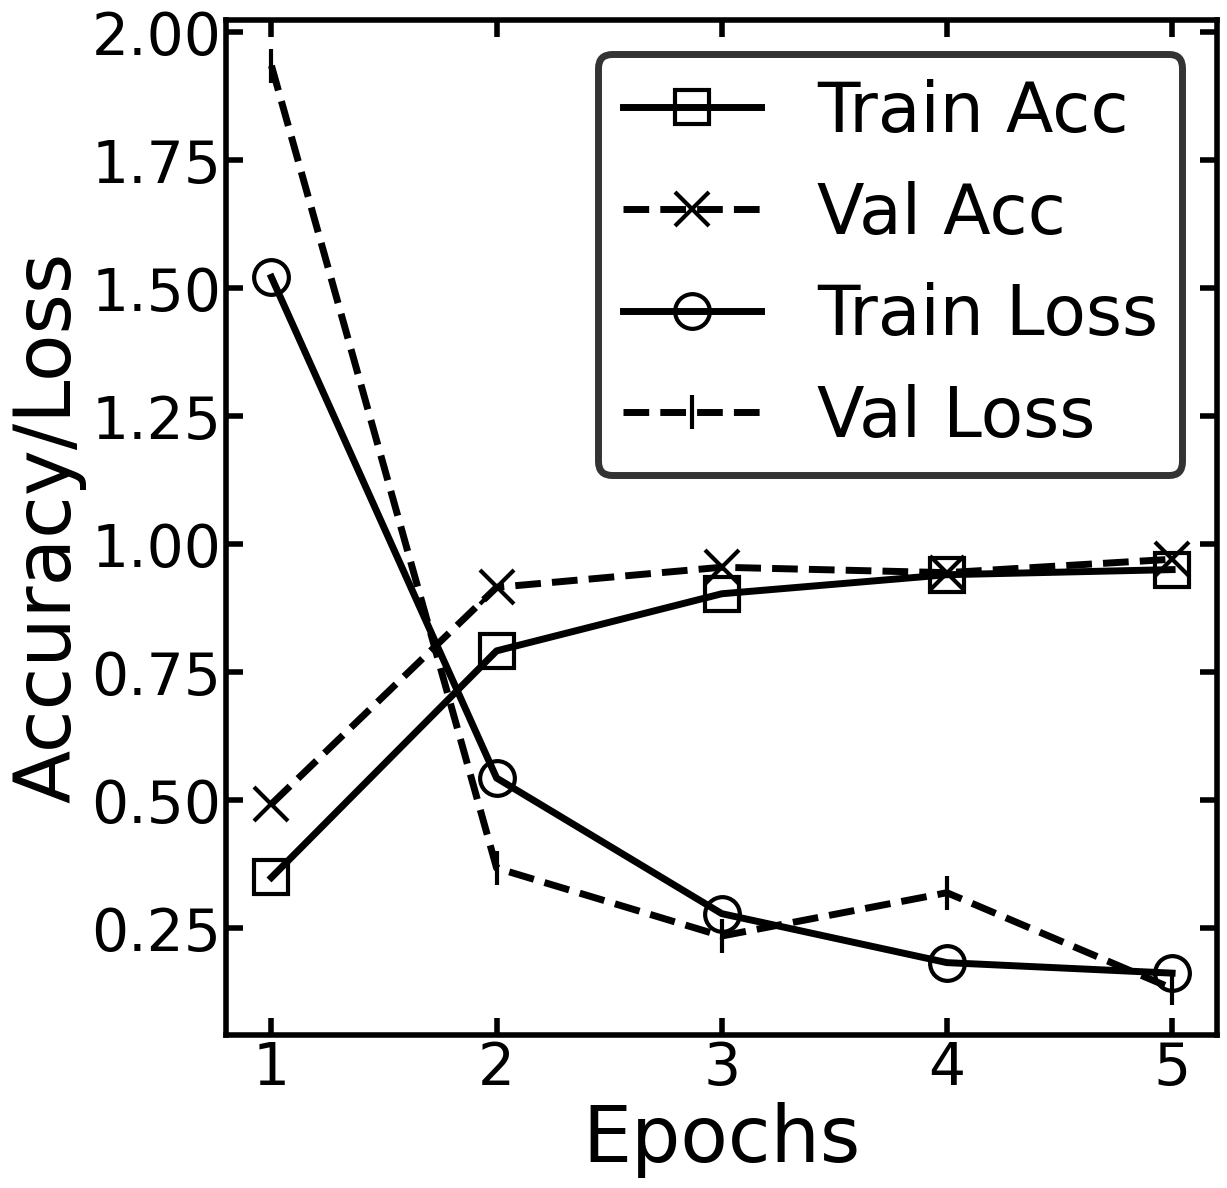

In [ ]:
#Convergence
plt.style.use("default")
plt.figure(figsize = figsize, 
           dpi = dpi, 
           edgecolor = 'black', 
           facecolor = 'white', 
           linewidth = 0)

plt.tight_layout()
plt.rc('xtick', labelsize = tick_font_size, direction="in") 
plt.rc('ytick', labelsize = tick_font_size, direction="in") 

fig, ax = plt.subplots(figsize = figsize)
plt.gcf().subplots_adjust(bottom = 0.15)
plt.setp(ax.spines.values(), linewidth = spine_axis_thickness)

plt.tick_params(length = tick_length, 
                width = tick_width, 
                right = True, 
                top = True)

plt.plot(np.arange(1, epochs + 1), 
         history.history["accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_accuracy, 
         lw = line_width_train, 
         marker = marker_train_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, 
         label = train_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["val_accuracy"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_accuracy, 
         lw = line_width_val, 
         marker = marker_validation_accuracy, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_accuracy_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_train_loss, 
         lw = line_width_train, 
         marker = marker_train_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_train, 
         ls = line_style_train, label = train_loss_label)

plt.plot(np.arange(1, epochs + 1), 
         history.history["val_loss"], 
         mew = marker_plot_markerwidth, 
         color = line_color_val_loss, 
         lw = line_width_val, 
         marker = marker_validation_loss, 
         markersize = marker_plot_markersize, 
         fillstyle = marker_fillstyle_validation, 
         ls = line_style_validation,  
         label = validation_loss_label)

plt.xlabel("Epochs", fontfamily = x_label_font, fontsize = x_label_font_size, color ='black')
plt.ylabel("Accuracy/Loss", fontfamily = y_label_font, fontsize = y_label_font_size, color = 'black')

legend = plt.legend(loc = legend_location, 
                    ncol = legend_ncol, 
                    frameon = legend_has_frame, 
                    fontsize=legend_font_size, 
                    edgecolor=legend_edge_color, 
                    borderpad=legend_border_pad, 
                    labelspacing=legend_label_spacing)

frame = legend.get_frame()
legend.get_frame().set_linewidth(legend_line_width)
legend.get_frame().set_edgecolor(legend_edge_color)
plt.setp(legend.texts, family = legend_font)
plt.tight_layout()

              precision    recall  f1-score   support

           0     1.0000    0.9800    0.9899       500
           1     0.9691    0.9400    0.9543       500
           2     0.9205    0.9720    0.9455       500
           3     0.9960    0.9900    0.9930       500

    accuracy                         0.9705      2000
   macro avg     0.9714    0.9705    0.9707      2000
weighted avg     0.9714    0.9705    0.9707      2000

Normalized confusion matrix
[[0.98  0.    0.02  0.   ]
 [0.    0.94  0.056 0.004]
 [0.    0.028 0.972 0.   ]
 [0.    0.002 0.008 0.99 ]]


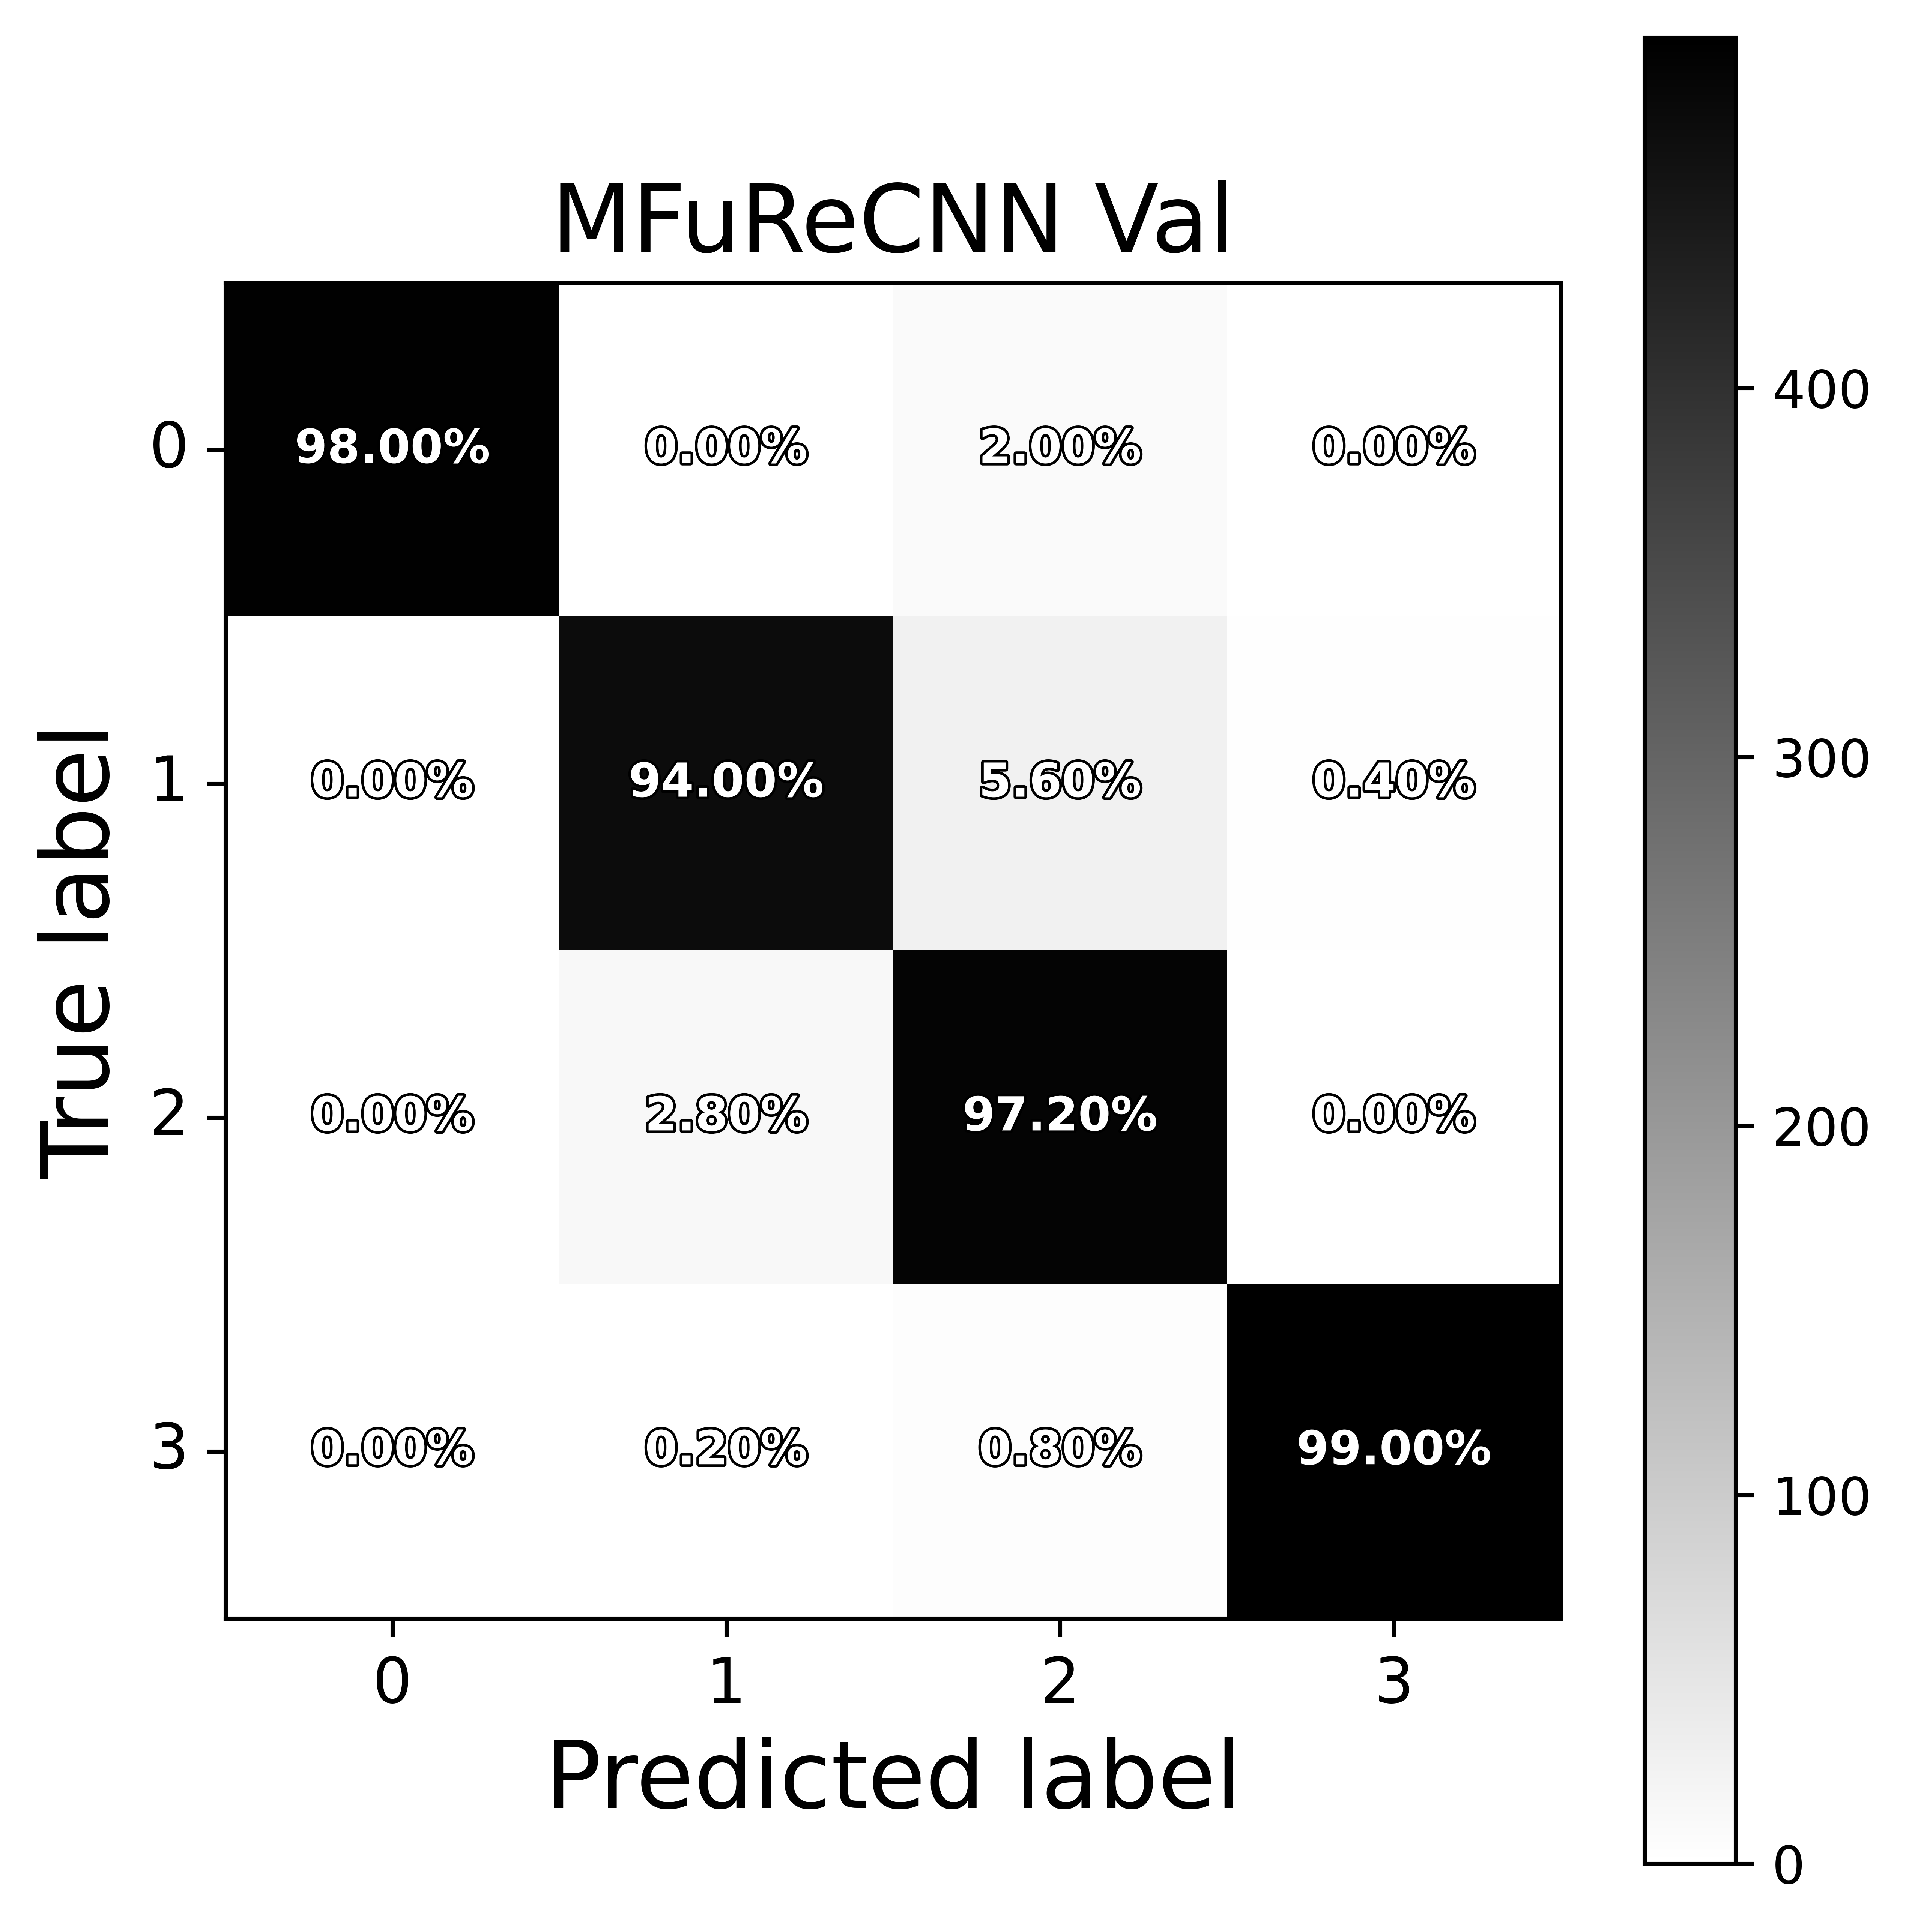

In [ ]:
# Confusion Matrix (Normalized)
fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title=model._name + ' Val',
                          cmap=plt.cm.binary):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                         horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['0', '1', '2', '3'] #0-Normal, 1-Ulcer, 2-Polyps, 3-Esophagitis
print(classification_report(Y_test,y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(Y_test,y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=dpi)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

plt.show()

In [ ]:
#Re-updated plotting format for CURVES
plt.rcParams.update({'figure.figsize': [6,6]})
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.borderpad': 0.2})
plt.rcParams.update({'legend.fontsize': 'xx-large'})
plt.rcParams.update({'legend.frameon': True})

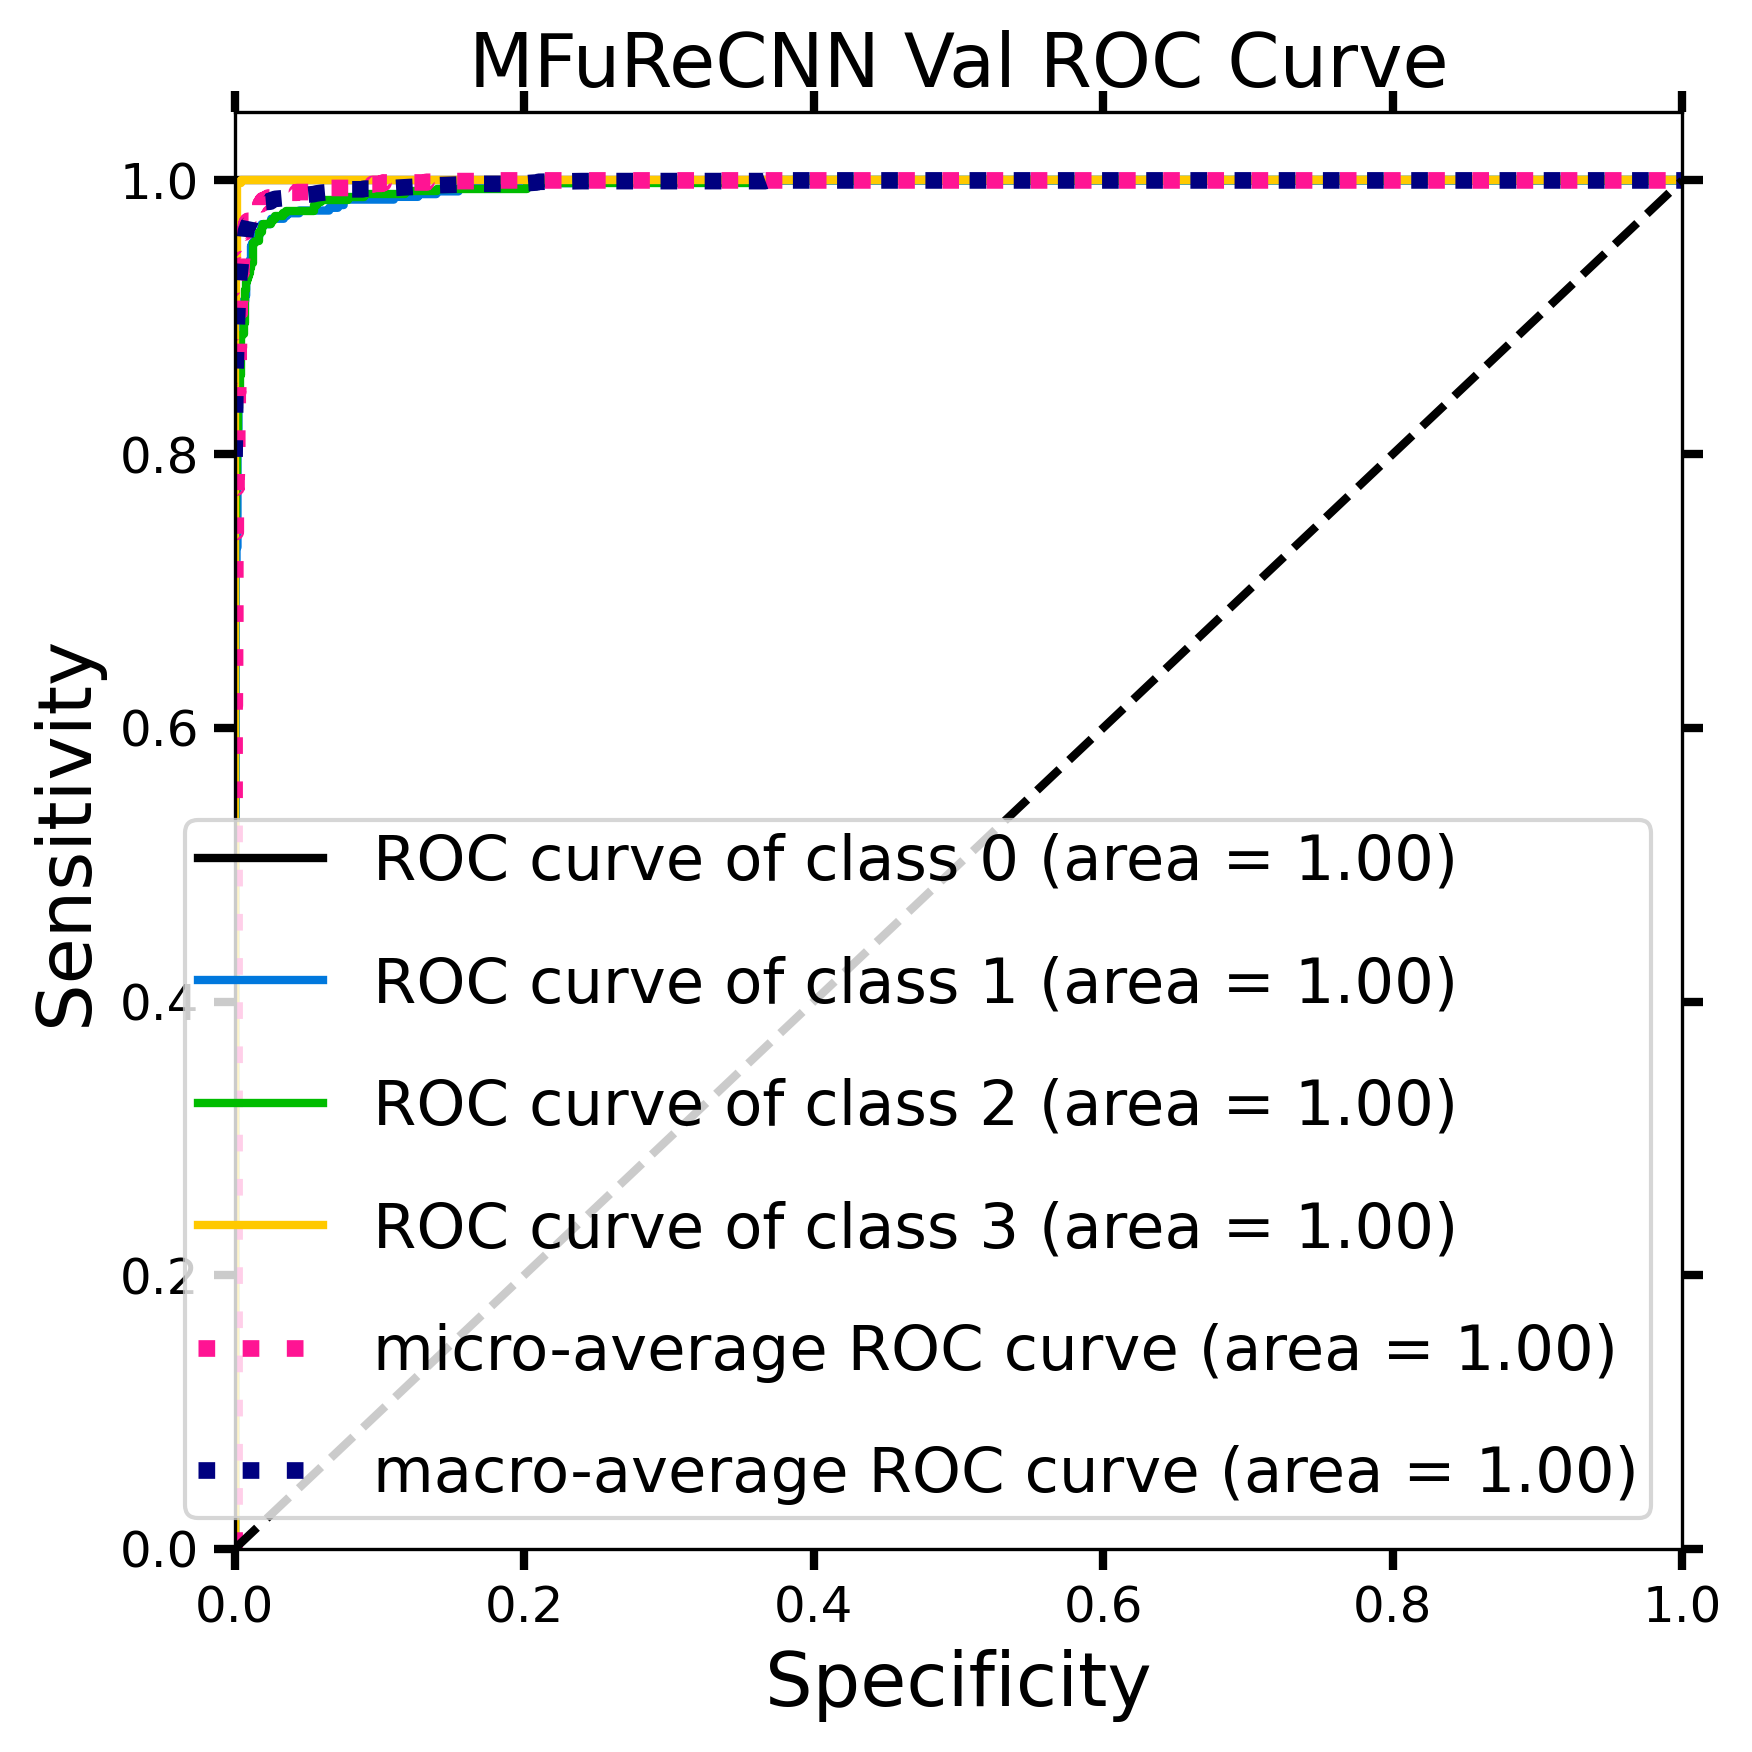

In [ ]:
#ROC validation
scikitplot.metrics.plot_roc(Y_test, y_pred)
plt.title(model._name + ' Val' + ' ROC Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Specificity', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Sensitivity', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
legend = plt.legend(loc="lower right", fontsize=15, labelspacing=1)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()



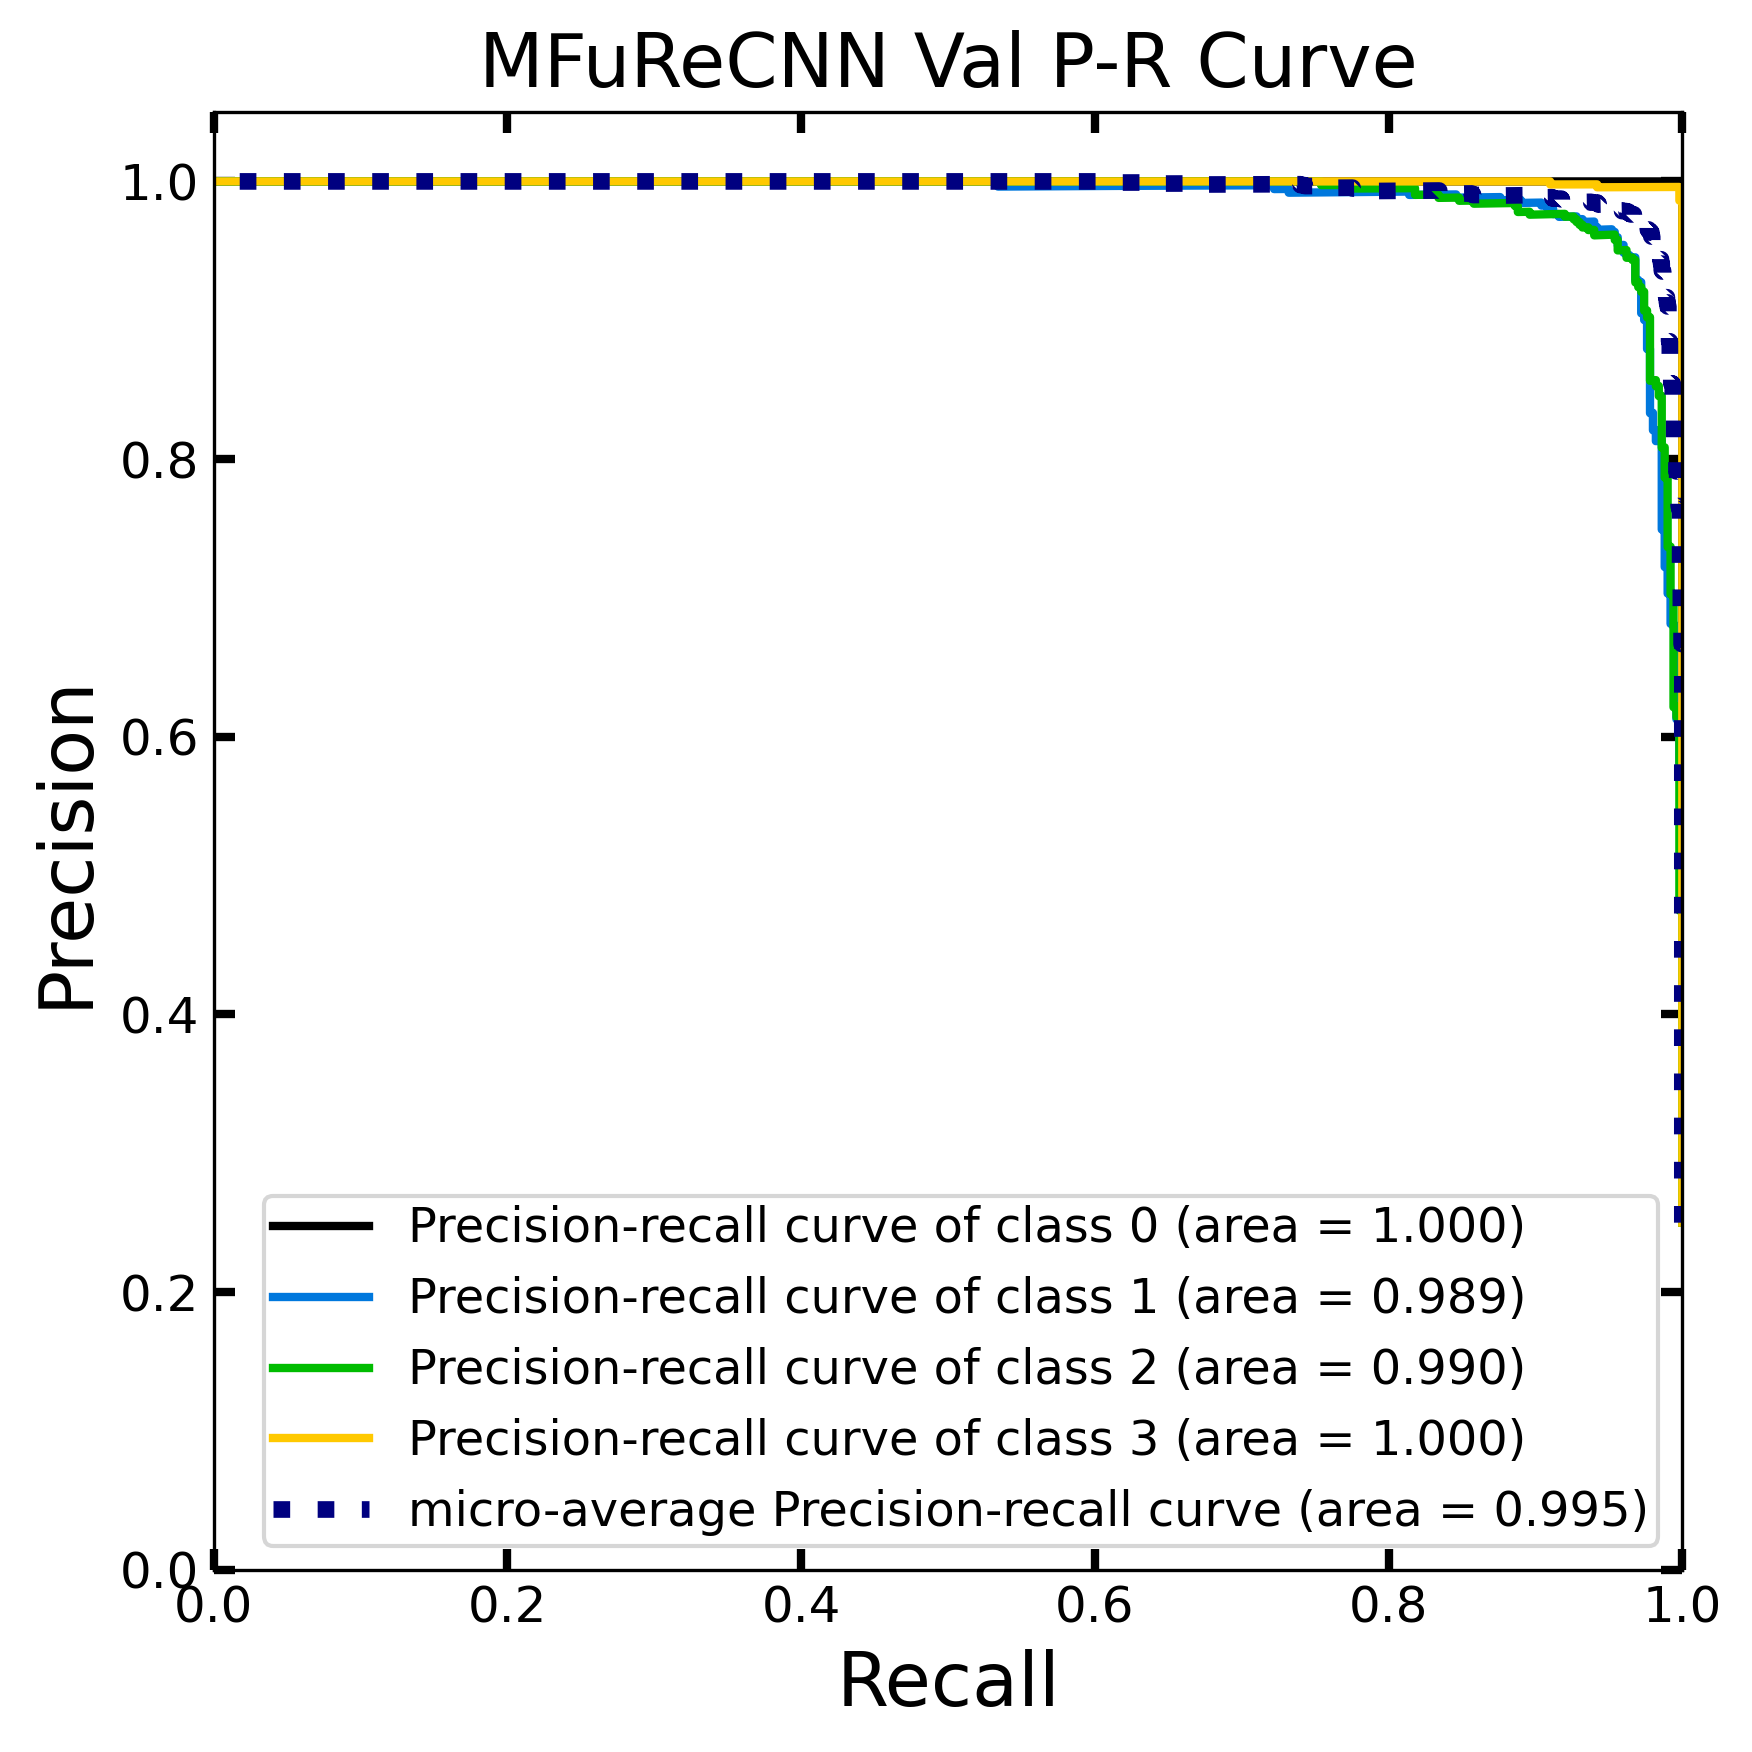

In [ ]:
#P-R validation
scikitplot.metrics.plot_precision_recall(Y_test, y_pred)
plt.title(model._name + ' Val' + ' P-R Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Recall', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Precision', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
plt.legend(loc="lower right", fontsize=11.5, labelspacing=0.5)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

In [ ]:
#Sanity check for validation
model.evaluate(validation_generator, return_dict=True)

63/63 [==============================] - 511s 8s/step - loss: 0.1306 - accuracy: 0.9705


{'loss': 0.13056086003780365, 'accuracy': 0.9704999923706055}

In [ ]:


#Evaluate test accuracy
y_pred_test = model.predict(test_generator, 
                                 nb_test_samples/batch_size, workers=1)

accuracy_test = accuracy_score(test_labels, y_pred_test.argmax(axis=-1))
print('The test accuracy of the ' + model._name + ' is: ', accuracy_test)

#evaluate mean squared error
mse_test = mean_squared_error(test_labels, y_pred_test.argmax(axis=-1))
print('The test MSE of the ' + model._name + ' is: ', mse_test)

#evaluate mean squared log error
msle_test = mean_squared_log_error(test_labels, y_pred_test.argmax(axis=-1))  
print('The test MSLE of the ' + model._name +  ' is: ', msle_test)



25/25 [==============================] - 197s 8s/step
The test accuracy of the MFuReCNN is:  0.96625
The test MSE of the MFuReCNN is:  0.05625
The test MSLE of the MFuReCNN is:  0.012459548562171978


              precision    recall  f1-score   support

           0     1.0000    0.9750    0.9873       200
           1     0.9684    0.9200    0.9436       200
           2     0.9065    0.9700    0.9372       200
           3     0.9950    1.0000    0.9975       200

    accuracy                         0.9663       800
   macro avg     0.9675    0.9663    0.9664       800
weighted avg     0.9675    0.9663    0.9664       800



Normalized confusion matrix
[[0.975 0.    0.025 0.   ]
 [0.    0.92  0.075 0.005]
 [0.    0.03  0.97  0.   ]
 [0.    0.    0.    1.   ]]


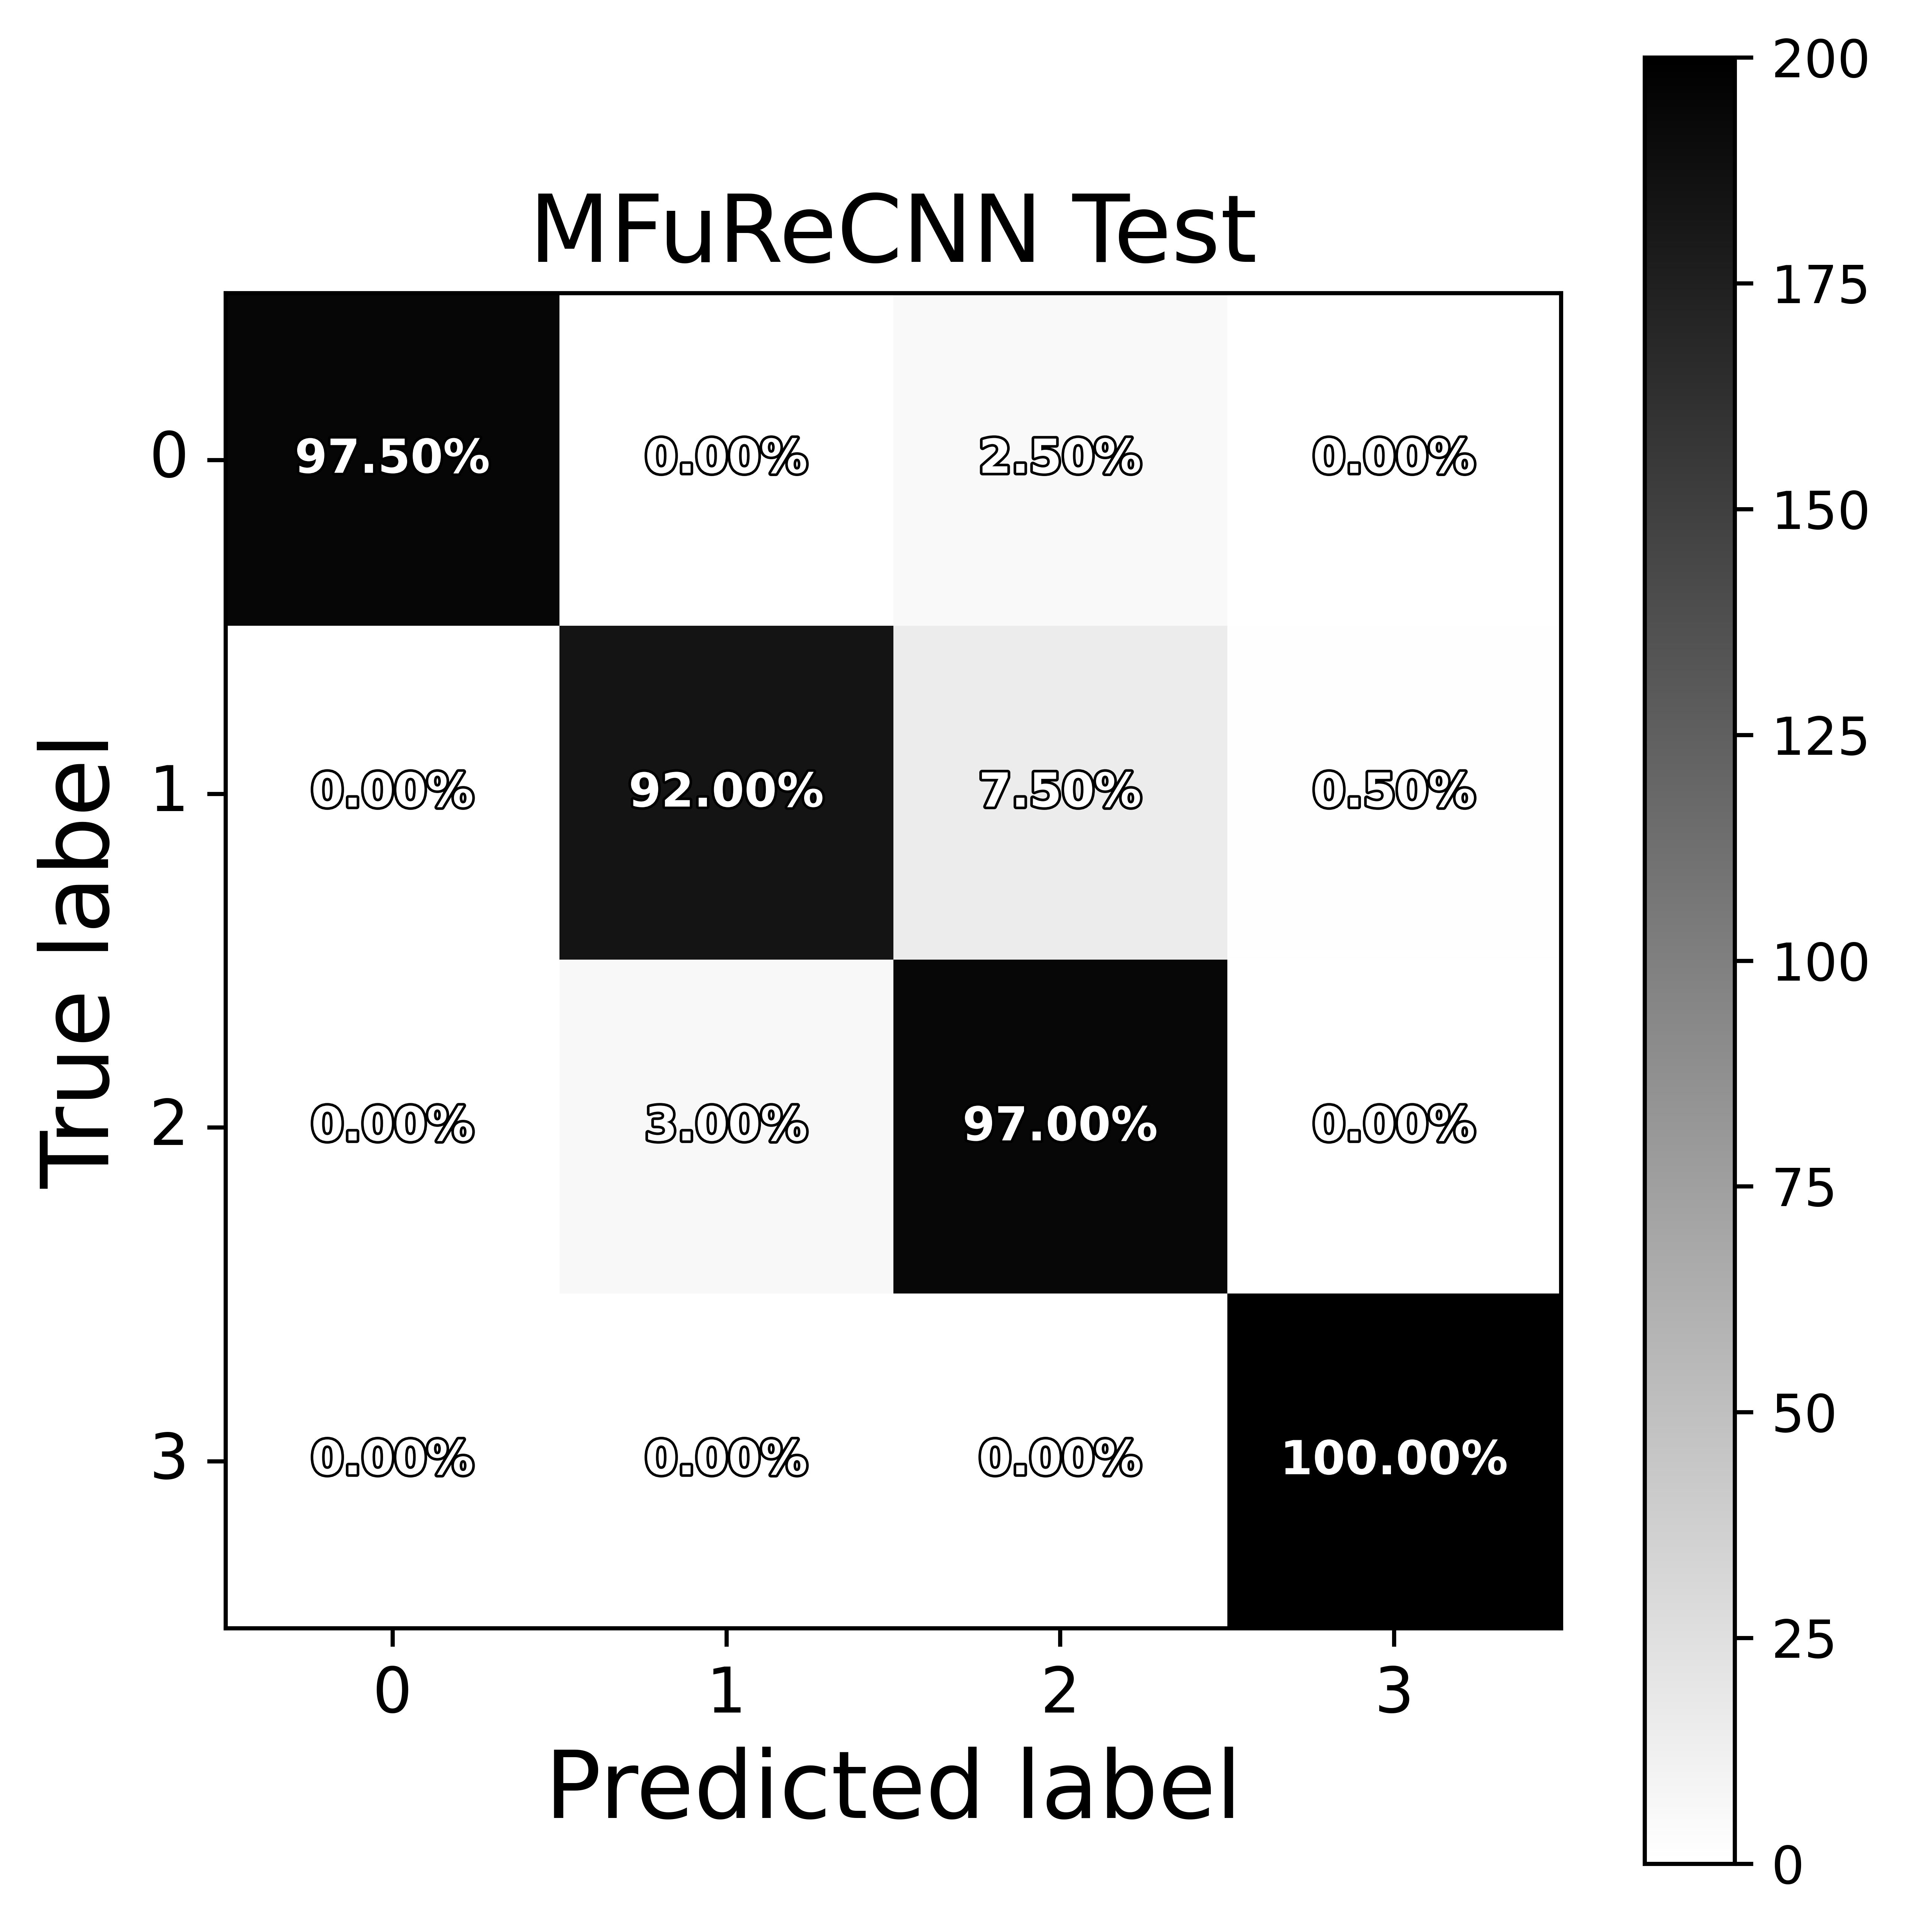

In [ ]:
# Confusion Matrix (Normalized)
fontsize=12

def confusion_matrix_test(cm, classes,
                          normalize=True, #if true all values in confusion matrix is between 0 and 1
                          title=model._name + ' Test',
                          cmap=plt.cm.binary):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar(orientation='vertical')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, horizontalalignment="center")
    plt.yticks(tick_marks, classes, rotation=0, fontfamily = 'Tahoma', fontsize=fontsize, verticalalignment="center")

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = plt.text(j, i, '{:.2f}%'.format(cm[i, j]*100),
                 fontfamily = 'Tahoma', 
                 fontsize=9, weight='bold',
                        horizontalalignment="center", verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "white")
        text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'), 
        path_effects.Normal()]),

    
    plt.tight_layout()
    plt.ylabel('True label', fontfamily = 'Tahoma', fontsize=18, horizontalalignment="center")
    plt.xlabel('Predicted label', fontfamily = 'Tahoma', fontsize=18)

#print classification report and plot confusion matrix
plt.style.use("default")
target_names = ['0', '1', '2', '3'] #0-Normal, 1-Ulcer, 2-Polyps, 3-Esophagitis
print(classification_report(test_labels, y_pred_test.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix_test = confusion_matrix(test_labels, y_pred_test.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5.25, 5.25), dpi=dpi)
confusion_matrix_test(cnf_matrix_test, classes=target_names)
plt.tight_layout()

plt.show()

In [ ]:
#Re-updated plotting format for CURVES
plt.rcParams.update({'figure.figsize': [6,6]})
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'legend.borderpad': 0.2})
plt.rcParams.update({'legend.fontsize': 'xx-large'})
plt.rcParams.update({'legend.frameon': True})

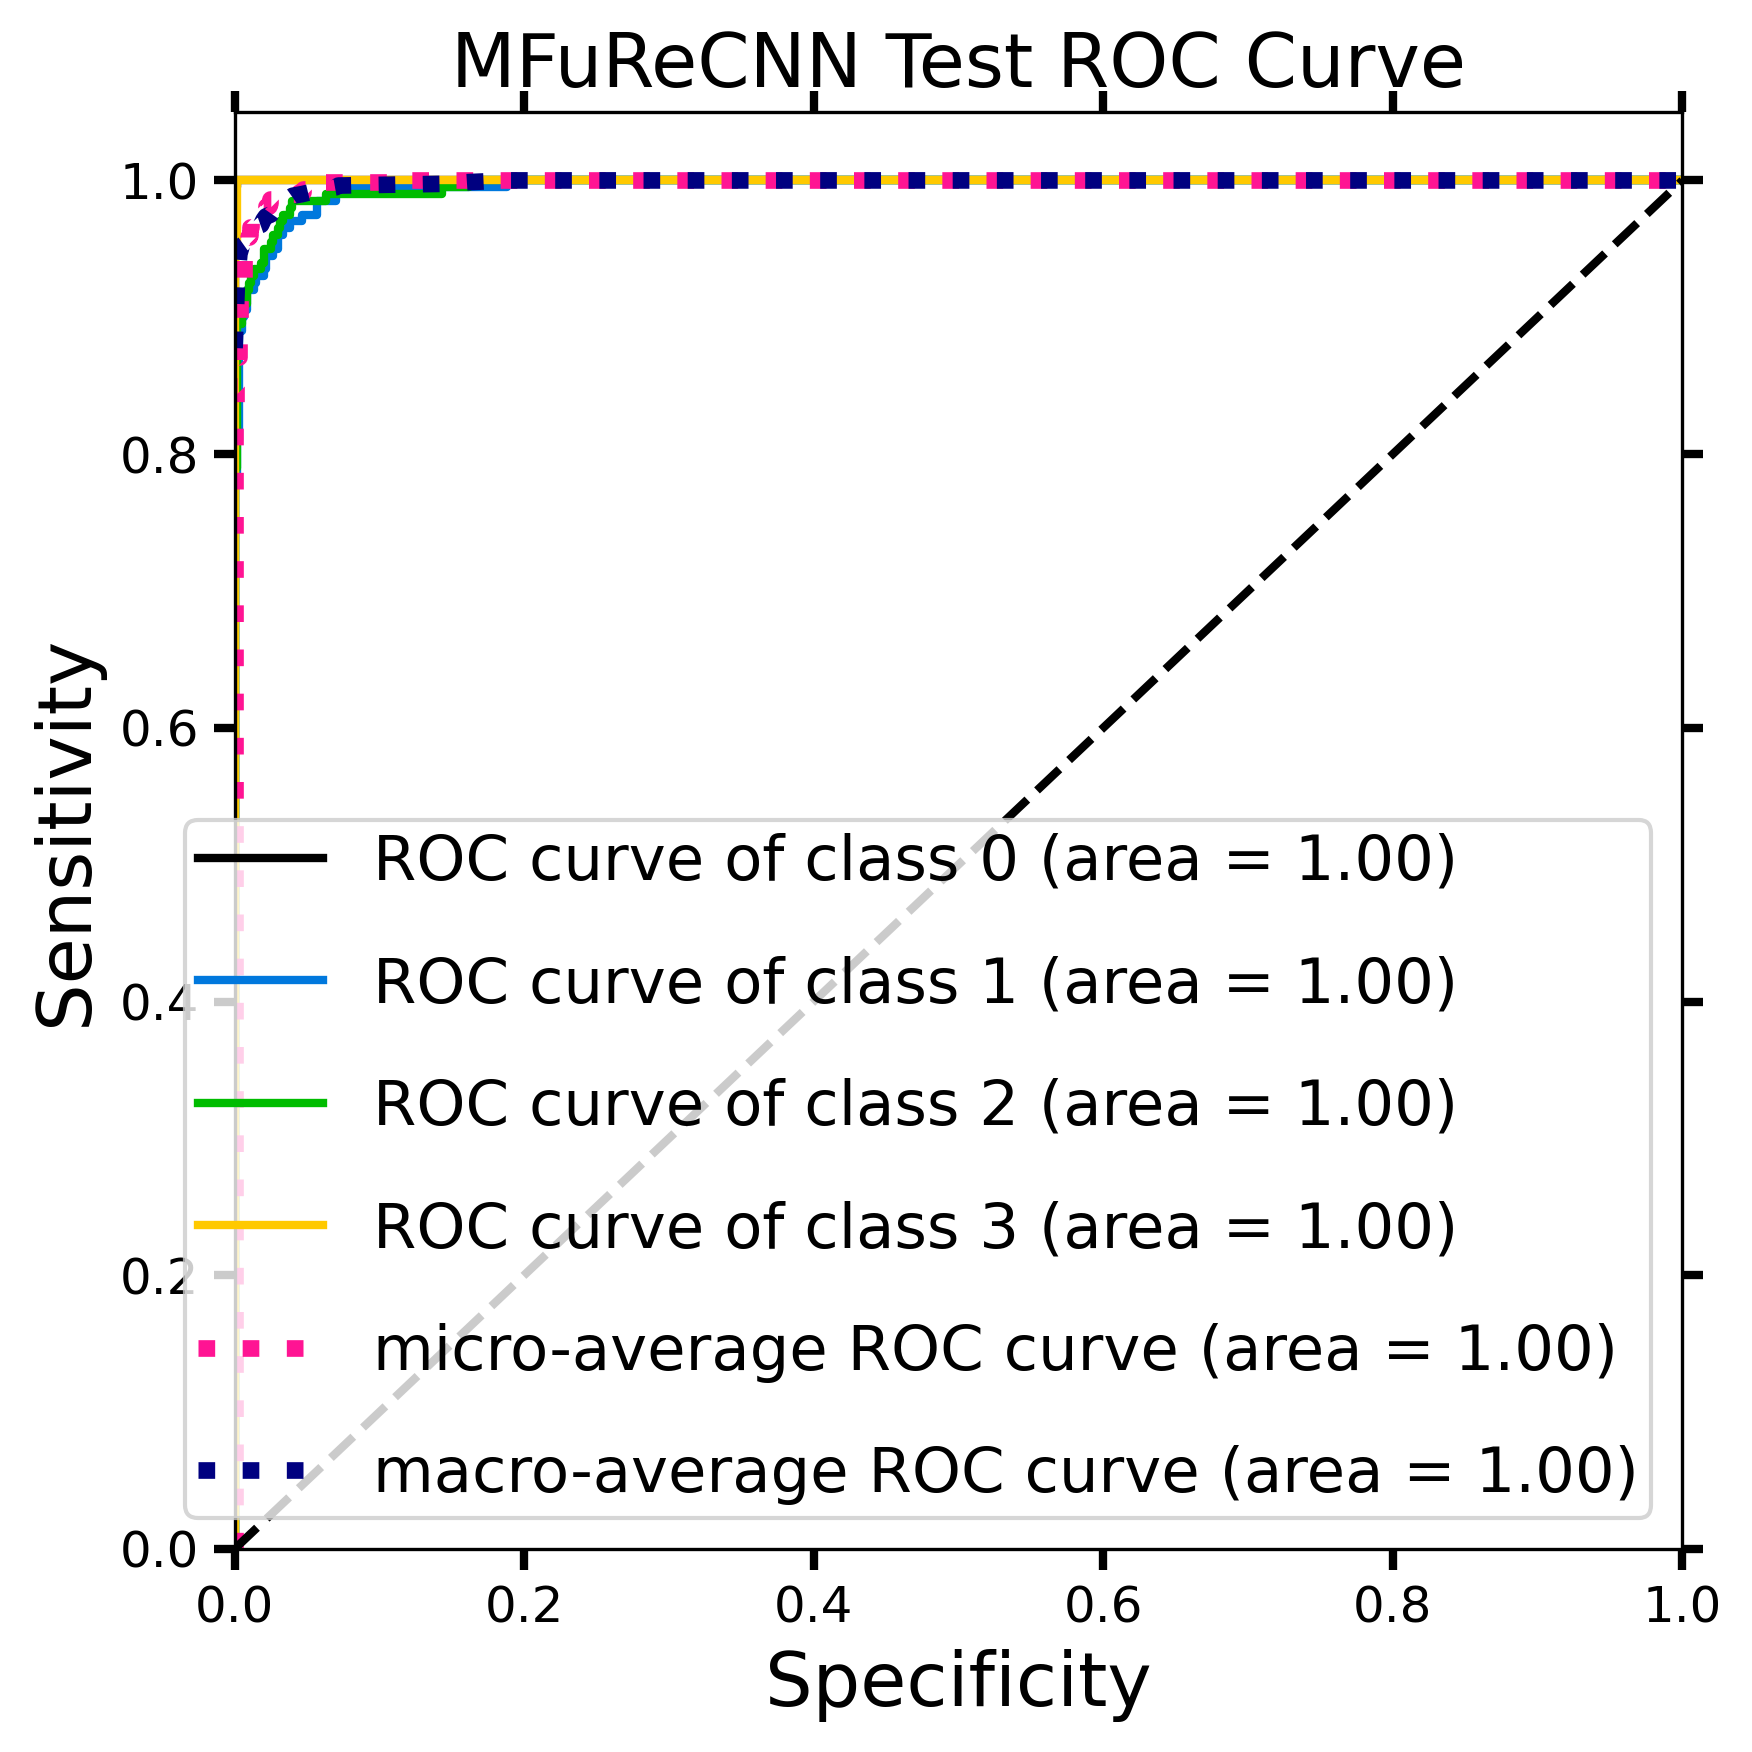

In [ ]:
#ROC test
scikitplot.metrics.plot_roc(test_labels, y_pred_test)
plt.title(model._name + ' Test' + ' ROC Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Specificity', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Sensitivity', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
legend = plt.legend(loc="lower right", fontsize=15, labelspacing=1)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

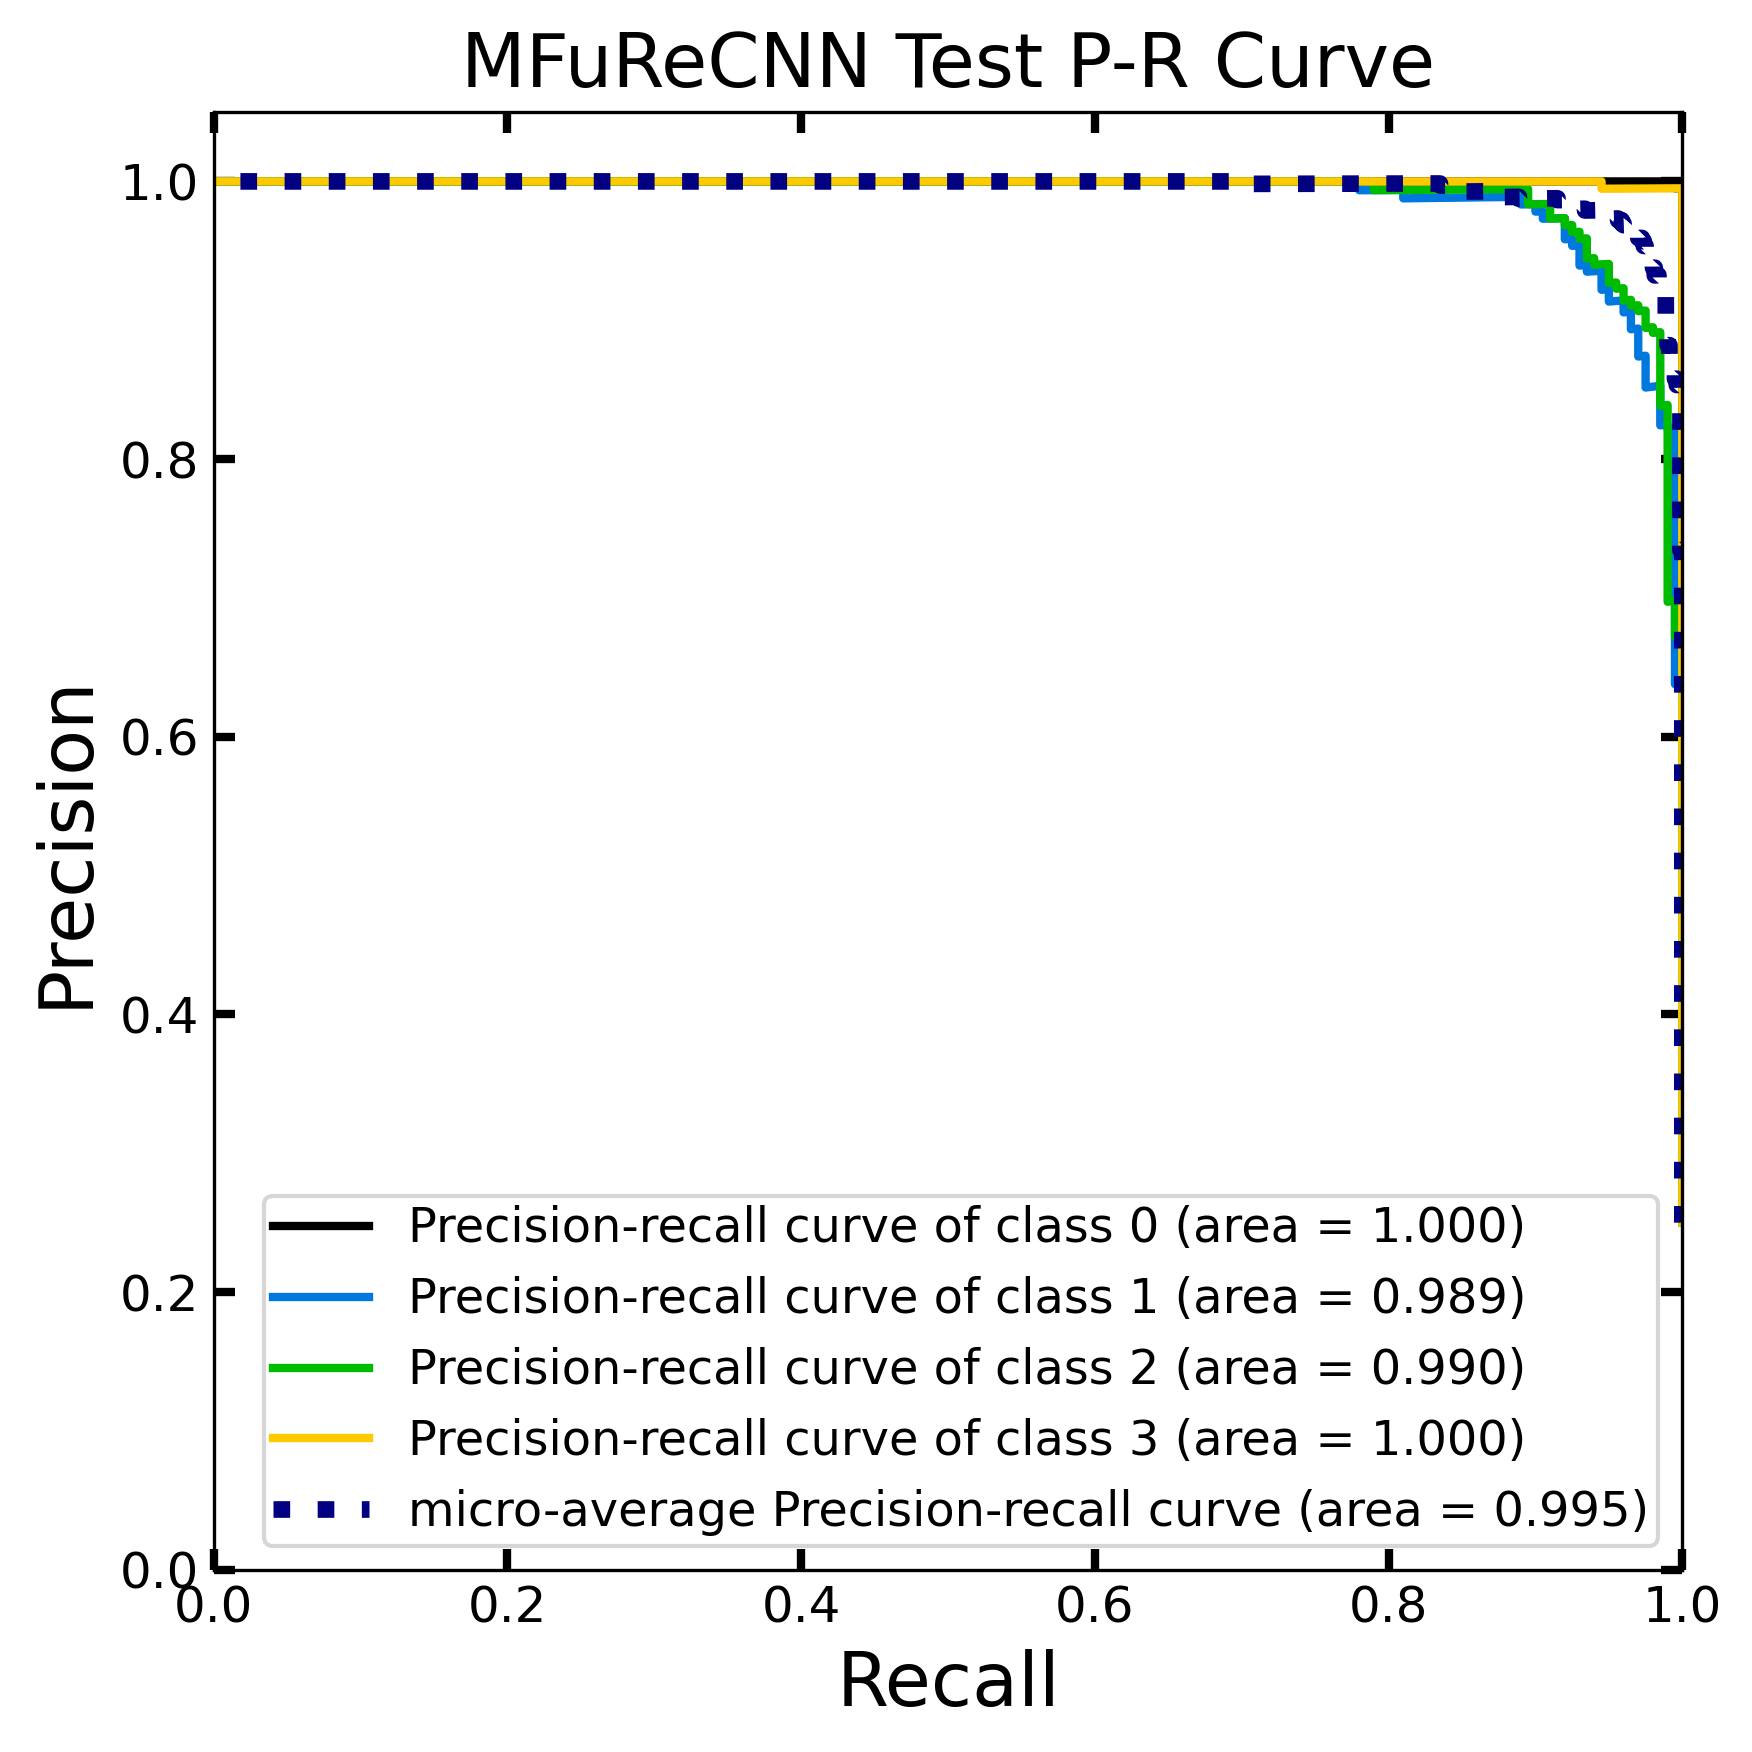

In [ ]:
#P-R test
scikitplot.metrics.plot_precision_recall(test_labels, y_pred_test)
plt.title(model._name + ' Test' + ' P-R Curve', fontsize=18, fontfamily='Tahoma')
plt.xlabel('Recall', fontsize=18, fontfamily='Tahoma')
plt.ylabel('Precision', fontsize=18, fontfamily='Tahoma')

plt.tick_params(length = 5, 
                width = 2, 
                right = True, 
                top = True, 
                labelsize = 12)

plt.rc('xtick', direction="in") 
plt.rc('ytick', direction="in") 
plt.legend(loc="lower right", fontsize=11.5, labelspacing=0.5)
plt.setp(legend.texts, family = 'Tahoma')

plt.tight_layout()
plt.show()

In [ ]:
#Sanity check for test
model.evaluate(test_generator, return_dict=True)

25/25 [==============================] - 205s 8s/step - loss: 0.1599 - accuracy: 0.9663


{'loss': 0.15993231534957886, 'accuracy': 0.9662500023841858}

In [ ]:
#Cost-efficiency
def cost_compute():
    flops  = float("{0:.2f}".format(get_flops(Model(model.input, model.output), batch_size=1)/ 10 ** 9))
    params = float("{0:.2f}".format(model.count_params() / 10 ** 6))
    trainable_count = float("{0:.2f}".format(count_params(model.trainable_weights) / 10 ** 6))
    print("FLOPS:", flops, "GFLOPS")
    print("Params:", params, "M")

cost_compute()

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS: 16.17 GFLOPS
Params: 37.85 M
